# Developing and Evaluating Intrusion Detection Systems (IDS)

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.models import Model
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials, SparkTrials, space_eval
from hyperopt.early_stop import no_progress_loss
import mlflow
from mlflow.models.signature import infer_signature
import sdv
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer
import torch
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Print versions
print(mlflow.__version__)
print(tf.__version__)
print(sdv.version.public)

# MLflow configuration
mlflow.tensorflow.autolog()


2024-04-03 16:58:18.171739: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 16:58:18.171811: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 16:58:18.171849: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-03 16:58:18.180700: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.9.2
2.14.1
1.11.0


## Data Preparation 


In [0]:
# Load dataset 
processed_file_path = '/dbfs/FileStore/m332479/GANs_forCyberSecurity/processed_RT_IOT2022.csv'
df = pd.read_csv(processed_file_path , index_col=0).reset_index()
df = df.dropna()

from sklearn.model_selection import train_test_split

# Splitting the dataset into 80% training and 20% test
# The stratify parameter ensures proportional allocation based on the 'Attack_type' column
train_df, test_df = train_test_split(df, test_size=0.20, stratify=df['Attack_type'], random_state=42)

# Checking the proportions in each set
print("Training set:")
print(train_df['Attack_type'].value_counts(normalize=True))
print("\nTest set:")
print(test_df['Attack_type'].value_counts(normalize=True))

Training set:
DOS_SYN_Hping          0.769669
Thing_Speak            0.065922
ARP_poisioning         0.063015
MQTT_Publish           0.033713
NMAP_UDP_SCAN          0.021059
NMAP_OS_DETECTION      0.016262
NMAP_XMAS_TREE_SCAN    0.015815
NMAP_TCP_scan          0.008151
DDOS_Slowloris         0.004340
Wipro_bulb             0.002053
Name: Attack_type, dtype: float64

Test set:
DOS_SYN_Hping          0.769656
Thing_Speak            0.065940
ARP_poisioning         0.063013
MQTT_Publish           0.033702
NMAP_UDP_SCAN          0.021059
NMAP_OS_DETECTION      0.016261
NMAP_XMAS_TREE_SCAN    0.015814
NMAP_TCP_scan          0.008131
DDOS_Slowloris         0.004350
Wipro_bulb             0.002073
Name: Attack_type, dtype: float64


##  Single Table Metadata API

In [0]:
# Single Table Metadata API

train_metadata = SingleTableMetadata()
test_metadata = SingleTableMetadata()
train_metadata.detect_from_dataframe(train_df)
test_metadata.detect_from_dataframe(test_df)
print(train_metadata)

{
    "columns": {
        "fwd_init_window_size": {
            "sdtype": "numerical"
        },
        "id_resp_p": {
            "sdtype": "numerical"
        },
        "fwd_pkts_payload_avg": {
            "sdtype": "numerical"
        },
        "fwd_pkts_payload_min": {
            "sdtype": "numerical"
        },
        "fwd_URG_flag_count": {
            "sdtype": "categorical"
        },
        "flow_SYN_flag_count": {
            "sdtype": "numerical"
        },
        "fwd_header_size_min": {
            "sdtype": "numerical"
        },
        "fwd_header_size_max": {
            "sdtype": "numerical"
        },
        "flow_pkts_payload_tot": {
            "sdtype": "numerical"
        },
        "flow_pkts_payload_max": {
            "sdtype": "numerical"
        },
        "flow_iat_min": {
            "sdtype": "numerical"
        },
        "payload_bytes_per_second": {
            "sdtype": "numerical"
        },
        "fwd_last_window_size": {
            "sd

## Initialize MLFlow Experments

In [0]:
# COMMAND ----------
mlflow.end_run()
# Initializes an MLflow experiment for tracking machine learning tasks. 
# It checks if the specified experiment already exists and creates it if not, storing the experiment ID.
dbutils.widgets.text("mlflow_exp_root_path","/Users/m332479@azg.pwus.us/ml_experments")

from mlflow.tracking import MlflowClient
mlflow_exp_root_path = dbutils.widgets.get("mlflow_exp_root_path")
client = MlflowClient()

## Test if experiment already exists
exp_name = f"{mlflow_exp_root_path}/cGAN_bestmodel"
if exp_name in [x.name for x in client.search_experiments()]:
    exp = mlflow.set_experiment(exp_name)
    experiment_id = exp.experiment_id
else:
    ## Create an experiment for runs started from a repo notebook
    experiment_id = client.create_experiment(f"{mlflow_exp_root_path}/cGAN_bestmodel")
experiment_id


'482022098609572'

In [0]:
study = 'march22'

run_name = f'cGAN_bestmodel{study}'
exp_id = experiment_id

In [0]:
CGAN_RT_IOT2022 = CTGANSynthesizer(
    train_metadata, # required
    enforce_rounding=False,
    epochs=1000,
    batch_size = 500,
    discriminator_dim = (512, 512),
    discriminator_decay = 2e-4,
    discriminator_steps = 1,
    embedding_dim = 128,
    generator_decay = 1e-4,
    generator_dim = (512, 512),
    generator_lr = 2e-4,
    log_frequency = True,
    pac = 10,
    verbose=True,
    cuda = True,
)
mlflow.log_param("epochs", 1000)
mlflow.log_param("batch_size", 500)
mlflow.log_param("discriminator_dim", (512, 512))
mlflow.log_param("generator_dim", (512, 512))
mlflow.log_param("discriminator_decay", 2e-4)
mlflow.log_param("generator_decay", 2e-4)
mlflow.log_param("generator_lr", 1e-4)

print("Best Parameters: ", CGAN_RT_IOT2022.get_parameters())
print("---------------------------------------------------")
print("Training...")
print("---------------------------------------------------")
CGAN_RT_IOT2022.fit(train_df)


/local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.10/site-packages/sdv/single_table/base.py:80: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Best Parameters:  {'enforce_min_max_values': True, 'enforce_rounding': False, 'locales': ['en_US'], 'embedding_dim': 128, 'generator_dim': (512, 512), 'discriminator_dim': (512, 512), 'generator_lr': 0.0002, 'generator_decay': 0.0001, 'discriminator_lr': 0.0002, 'discriminator_decay': 0.0002, 'batch_size': 500, 'discriminator_steps': 1, 'log_frequency': True, 'verbose': True, 'epochs': 1000, 'pac': 10, 'cuda': True}
---------------------------------------------------
Training...
---------------------------------------------------


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f2d3491f760>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_ca

### Save Finetuned Model

In [0]:
'''
CGAN_RT_IOT2022.save(
    filepath='/dbfs/FileStore/m332479/GANs_forCyberSecurity/models/cGAN_RT_IDS_synthesizer.pkl'
)
 
'''
import joblib
joblib.dump(CGAN_RT_IOT2022, "/dbfs/FileStore/m332479/GANs_forCyberSecurity/models/CGAN_IOT_432024.joblib")


['/dbfs/FileStore/m332479/GANs_forCyberSecurity/models/CGAN_IOT_432024.joblib']

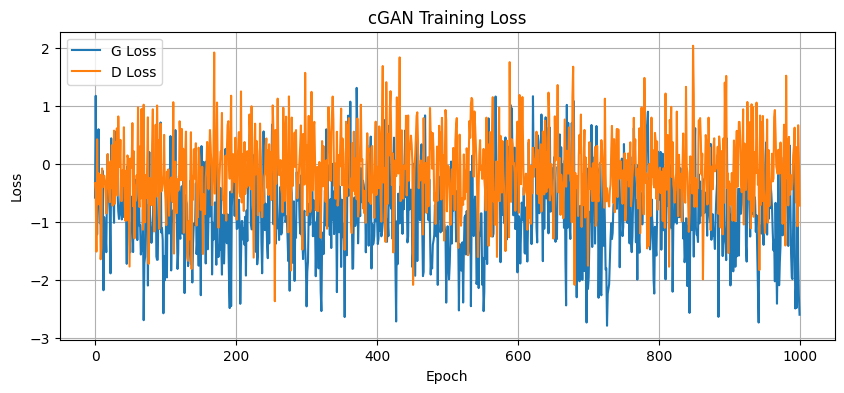

In [0]:

loss_df = CGAN_RT_IOT2022.get_loss_values()
# Set 'Epochs' as the index
loss_df.set_index('Epoch', inplace=True)
  
# Save the DataFrame as a CSV or log it as an artifact in MLflow
loss_df.to_csv("/dbfs/FileStore/m332479/GANs_forCyberSecurity/loss_df_cgan432024.csv")
mlflow.log_artifact("/dbfs/FileStore/m332479/GANs_forCyberSecurity/loss_df_cgan432024.csv")
mlflow.log_metric("Discriminator Loss", loss_df['Generator Loss'].mean())
mlflow.log_metric("Generator Loss", loss_df['Discriminator Loss'].mean())


# Plot the loss.
fig, ax = plt.subplots(figsize=(10, 4))
loss_df.plot(ax=ax)
plt.title('cGAN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['G Loss', 'D Loss'])
plt.grid(True)

# Make sure to use a correct path to save the plot.
plot_path =  "/dbfs/FileStore/m332479/GANs_forCyberSecurity/plots/loss_plot_432024.png"
plt.savefig(plot_path)

In [0]:
CGAN_RT_IOT2022.fit(test_df)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f2d342076d0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_ca

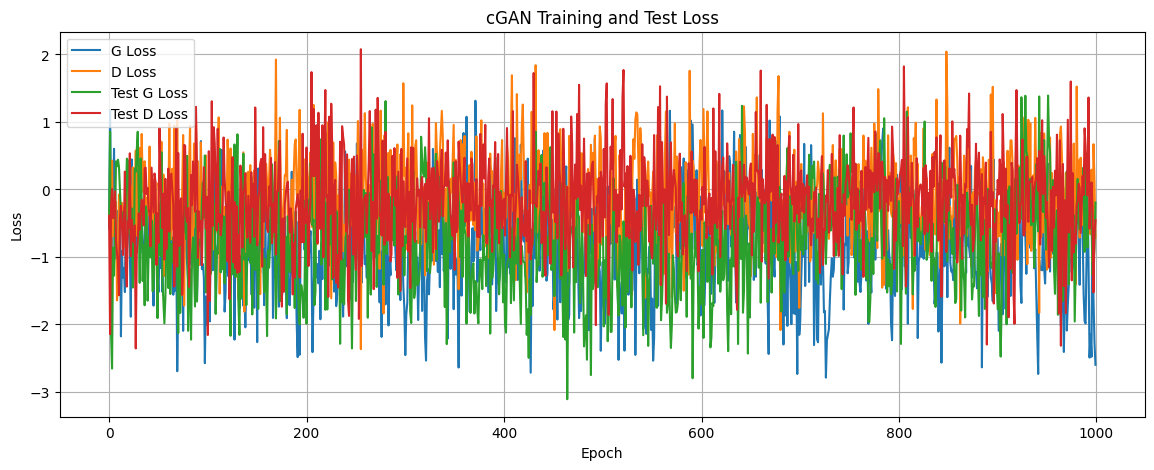

In [0]:
test_loss_df = CGAN_RT_IOT2022.get_loss_values()
# Set 'Epochs' as the index
test_loss_df.set_index('Epoch', inplace=True)
test_loss_df = test_loss_df.rename(columns = {"Discriminator Loss": "Test Discriminator Loss", "Generator Loss": "Test Generator Loss"})
loss_df_all = pd.concat([loss_df, test_loss_df])  
# Save the DataFrame as a CSV or log it as an artifact in MLflow
loss_df_all.to_csv("/dbfs/FileStore/m332479/GANs_forCyberSecurity/loss_df_all_cgan432024.csv")
mlflow.log_artifact("/dbfs/FileStore/m332479/GANs_forCyberSecurity/loss_df_all_cgan432024.csv")
mlflow.log_metric("Discriminator Loss", loss_df_all['Discriminator Loss'].mean())
mlflow.log_metric("Generator Loss", loss_df_all['Generator Loss'].mean())
mlflow.log_metric("Test Discriminator Loss", loss_df_all['Test Discriminator Loss'].mean())
mlflow.log_metric("Test Generator Loss", loss_df_all['Test Generator Loss'].mean())


# Plot the loss.
fig, ax = plt.subplots(figsize=(14, 5))
loss_df_all.plot(ax=ax)
plt.title('cGAN Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['G Loss', 'D Loss', 'Test G Loss', 'Test D Loss'])
plt.grid(True)

# Make sure to use a correct path to save the plot.
plot_path =  "/dbfs/FileStore/m332479/GANs_forCyberSecurity/plots/loss_plot_432024.png"
plt.savefig(plot_path)

In [0]:

mlflow.log_artifact("/dbfs/FileStore/m332479/GANs_forCyberSecurity/plots/loss_plot_432024.png")



In the context of a Conditional Generative Adversarial Network (CGAN), both the generator and the discriminator have specific roles:

`Generator`: It tries to generate data that is indistinguishable from real data, given some condition or class label.

`Discriminator`: It tries to distinguish between real data and the fake data generated by the generator.
During training, these two networks are in a sort of competition: the generator tries to improve its data generation to fool the discriminator, while the discriminator tries to get better at distinguishing real from fake.

`Loss Functions`: Typically, the loss functions for both networks are designed to measure how well each is performing its task.

`Generator Loss`: This often reflects how poorly the generator is at fooling the discriminator. A high loss means the discriminator can easily tell its data is fake, while a lower loss means the generator is producing more believable data.

`Discriminator Loss`: This reflects how well the discriminator is at identifying real and fake data. A high loss would mean the discriminator is often fooled by the generator, while a lower loss would mean it's proficient at telling real from fake.

`Negative Loss Values`: In the case of CGANs, or GANs in general, negative loss values can occur depending on the design of the loss functions. Some loss functions (like Wasserstein Loss) can naturally lead to negative values because they measure a kind of "distance" between distributions. Other reasons for negative losses can include:
Logarithms in Loss Functions: Traditional GAN loss functions involve logarithms, which can lead to negative values since the logarithm of a number between 0 and 1 is negative. 